In [1]:
!pip install torchvision==0.9.1 torch==1.8.1 
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

ERROR: Could not find a version that satisfies the requirement torchvision==0.9.1 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2)
ERROR: No matching distribution found for torchvision==0.9.1


In [2]:
IMAGE_SIZE = 16

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

In [4]:

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

View first 3 samples

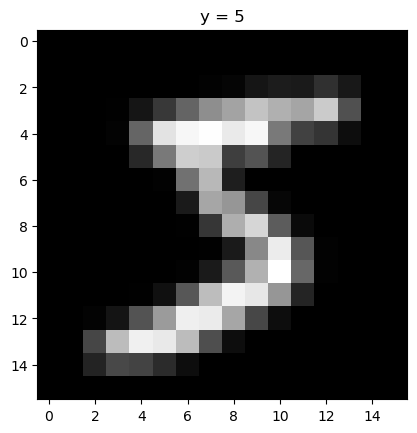

In [5]:

show_data(train_dataset[0])

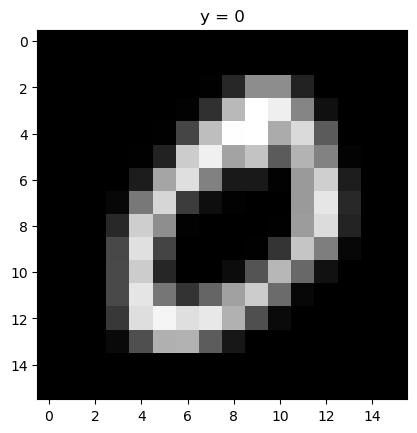

In [6]:
show_data(train_dataset[1])

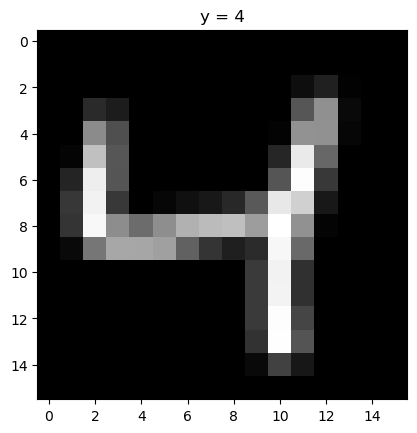

In [7]:
show_data(train_dataset[2])

In [8]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


In [9]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [46]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):
    
    #global variable 
    N_test=len(validation_dataset)
    accuracy_list=[]
    loss_list=[]
    cost_list=[]
    cost=0
    for epoch in range(n_epochs):
        cost=0
        for x, y in train_loader:
            model.train()
            # clear gradient
            optimizer.zero_grad()
            # make a prediction
            z = model(x)
            # calculate loss
            loss = criterion(z, y) 
            # calculate gradients of parameters
            loss.backward()  
            # update parameters
            optimizer.step()         
            cost+=loss.item()
            loss_list.append(loss.data)
        cost_list.append(cost)

        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list, cost_list

In [47]:
model = CNN(out_1=16, out_2=32)

In [48]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=500)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=500)

In [49]:
# Train the model for normal CNN

accuracy_list, loss_list, cost_list = train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

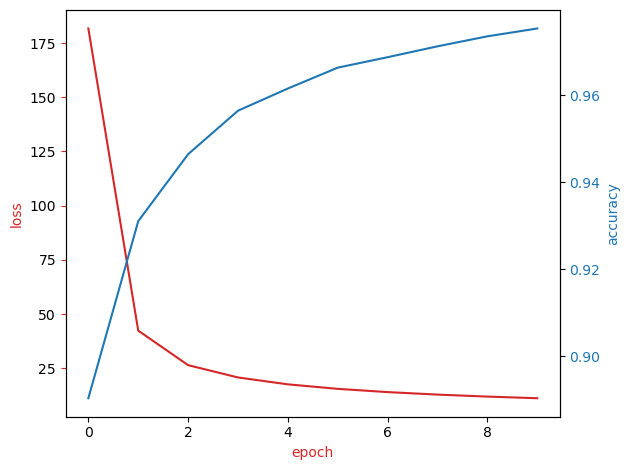

In [50]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('loss',color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()